In [1]:
import os
import re
import itertools
import warnings
from joblib import dump

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats, signal
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score

warnings.filterwarnings("ignore")
random_state = 42
activities = ["dab", "jamesbond", "mermaid", "pushback", "scarecrow", "snake", "window360", "cowboy", "logout"]
n_labels = len(activities)

In [2]:
dfs = []

def load_data(activity, label, files, subject):
    for file in files:
        df = pd.read_csv(os.path.join(subject, activity+str(file)+".csv"), sep=",", index_col=0)
        df["label"] = [label for _ in range(len(df))]
        df["activity"] = [activity for _ in range(len(df))]
        df["file"] = [file for _ in range(len(df))]
        df["subject"] = [subject for _ in range(len(df))]
        dfs.append(df)

ids = [1, 2, 3, 4, 5, 6, 7]
user = "subject1"
load_data("dab", 0, ids, user)
load_data("jamesbond", 1, ids, user)
load_data("mermaid", 2, ids, user)

user = "subject3"
load_data("dab", 0, ids, user)
load_data("jamesbond", 1, ids, user)
load_data("mermaid", 2, ids, user)

ids = [1, 2, 3, 4, 5, 6]
user = "subject2"
load_data("dab", 0, ids, user)
load_data("jamesbond", 1, ids, user)

ids = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
user = "subject1"
load_data("pushback", 3, ids, user)
load_data("scarecrow", 4, ids, user)
load_data("snake", 5, ids, user)
load_data("window360", 6, ids, user)
load_data("cowboy", 7, ids, user)
load_data("logout", 8, ids, user)

user = "subject3"
load_data("pushback", 3, ids, user)
load_data("scarecrow", 4, ids, user)
load_data("snake", 5, ids, user)
load_data("window360", 6, ids, user)
load_data("cowboy", 7, ids, user)
load_data("logout", 8, ids, user)

df = pd.concat(dfs)
print(df.shape)
df.head()

(52200, 13)


,yaw,pitch,roll,g_x,g_y,g_z,a_x,a_y,a_z,label,activity,file,subject
0,-0.05,12.99,72.28,-6.47,-2.95,-1.05,-0.20,1.00,-0.17,0,dab,1,subject1
1,-1.67,15.87,55.53,-67.89,11.78,-6.40,-0.26,1.29,-0.01,0,dab,1,subject1
2,-18.20,5.15,9.66,-180.85,-41.34,-70.00,-0.25,1.47,1.91,0,dab,1,subject1
3,23.60,7.15,-49.80,-250.14,7.11,91.12,-0.27,1.37,-0.11,0,dab,1,subject1
4,-10.80,23.43,-50.88,-4.71,59.81,-41.99,-0.66,-0.72,0.06,0,dab,1,subject1


In [3]:
def convert_to_timeseries(features, window_size, num_features):
    data = np.reshape(features, newshape=(window_size, num_features))
    return data.T

window_size = 30
X = list()
y = list()
df_len = len(df)
for idx in range(0, df_len, window_size):
    window_df = df[idx:idx+window_size]
    labels = window_df["label"].unique()
    files = window_df["file"].unique()
    subjects = window_df["subject"].unique()
    if len(labels) != 1 or len(files) != 1 or len(subjects) != 1 or len(window_df) < window_size:
        continue
    assert len(labels) == 1 and len(window_df) == window_size
    features = window_df.drop(columns=["label", "activity", "subject", "file"]).values
    features = convert_to_timeseries(features, window_size=window_size, num_features=9)
    X.append(features)
    y.append(labels)
     

X = np.array(X)
y = np.array(y)

X.shape, y.shape

((1740, 9, 30), (1740, 1))

In [4]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix'):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cmap='Blues'
        print("Confusion Matrix With Normalization")
    else:
        cmap='Greens'
        print('Confusion Matrix Without Normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True')
    plt.xlabel('Prediction')
#     plt.show()

In [5]:
def compute_mean(data):
    return np.mean(data)

def compute_variance(data):
    return np.var(data)

def compute_median_absolute_deviation(data):
    return stats.median_absolute_deviation(data)

def compute_root_mean_square(data):
    def compose(*fs):
        def wrapped(x):
            for f in fs[::-1]:
                x = f(x)
            return x
        return wrapped
    rms = compose(np.sqrt, np.mean, np.square)
    return rms(data)

def compute_kurtosis(data):
    return stats.kurtosis(data)

def compute_min_max(data):
    return np.max(data) - np.min(data)

def compute_spectral_entropy(data):
    freqs, power_density = signal.welch(data)
    return stats.entropy(power_density)

def compute_principle_frequency(data):
    freqs, power_density = signal.welch(data)
    return freqs[np.argmax(np.square(power_density))]

In [6]:
feature_names = []

# Rotation around the front-to-back axis is called roll.
# Rotation around the side-to-side axis is called pitch.
# Rotation around the vertical axis is called yaw.
for i in ["yaw", "pitch", "roll", "gyro_x", "gyro_y", "gyro_z", "acc_x", "acc_y", "acc_z"]:
        for j in ["_mean", "_var", "_mad", "_rms", "_kurtosis", "_min_max", "_entropy", "_pfreq"]:
            feature_names.append(i+j)

n_features = len(feature_names)

def extract_features_per_row(f_n):
    mean = compute_mean(f_n)
    var = compute_variance(f_n)
    mad = compute_median_absolute_deviation(f_n)
    rms = compute_root_mean_square(f_n)
    kurtosis = compute_kurtosis(f_n)
    min_max = compute_min_max(f_n)
    entropy = compute_spectral_entropy(f_n)
    pfreq = compute_principle_frequency(f_n)
    return mean, var, mad, rms, kurtosis, min_max, entropy, pfreq

def extract_features(X):
    new_features = np.ones((X.shape[0], n_features))

    for i in range(X.shape[0]):
        features = []
        for j in range(X.shape[1]):
            f_n = X[i][j]
            feature = extract_features_per_row(f_n)
            features.extend(feature)
        new_features[i] = np.array(features)
    print(new_features)

    return new_features

X = extract_features(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=random_state)

X_train.shape

[[-1.65600000e+00  9.05061451e+02  1.12603470e+01 ...  2.08000000e+00
   2.14686637e+00  4.66666667e-01]
 [-3.19333333e-01  1.02738219e+03  1.92663870e+01 ...  1.67000000e+00
   1.84534258e+00  4.00000000e-01]
 [ 1.40333333e-01  8.36102043e+02  6.67170000e+00 ...  1.52000000e+00
   2.16763364e+00  2.00000000e-01]
 ...
 [-1.06400000e+00  2.67424344e+02  2.10751590e+01 ...  5.70000000e-01
   1.32002764e+00  2.00000000e-01]
 [ 1.79166667e+00  2.99605754e+02  2.60122170e+01 ...  7.00000000e-01
   2.28489777e+00  2.00000000e-01]
 [ 3.57666667e-01  2.95832378e+02  2.32397550e+01 ...  8.90000000e-01
   1.92788333e+00  2.00000000e-01]]


(1165, 72)

In [7]:
X_test.shape

(575, 72)

In [8]:
scaler = preprocessing.StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
y_train = y_train.flatten()
y_train.shape

(1165,)

In [9]:
from pickle import dump

dump(scaler, open('scaler.pkl', 'wb'))

In [10]:
df2 = pd.DataFrame(X_train, columns=feature_names)
df2["activityName"] = y_train
df2["activityName"] = df2["activityName"].replace([0,1,2,3,4,5,6,7,8], activities)
df2

,yaw_mean,yaw_var,yaw_mad,yaw_rms,yaw_kurtosis,yaw_min_max,yaw_entropy,yaw_pfreq,pitch_mean,pitch_var,...,acc_y_pfreq,acc_z_mean,acc_z_var,acc_z_mad,acc_z_rms,acc_z_kurtosis,acc_z_min_max,acc_z_entropy,acc_z_pfreq,activityName
0,-0.048055,-0.692056,-0.701782,-0.822765,-0.380227,-0.892487,0.439602,-1.180342,0.285761,-0.087769,...,-0.604326,0.582818,-0.074817,-0.207234,-0.048381,-0.390616,-0.143117,-1.331515,-0.888528,mermaid
1,0.302569,-0.621332,-0.492800,-0.683384,-0.424807,-0.764063,0.531584,1.796061,0.436737,-0.108284,...,0.126385,-0.497695,-0.074828,-0.442056,-0.224073,-0.226570,-0.137426,1.256865,-0.041792,jamesbond
2,0.097137,1.183943,-0.517617,1.224513,0.350333,1.834562,0.376034,-0.064191,0.403596,0.212483,...,-0.969682,0.897518,-0.005661,0.702705,0.730224,6.090165,0.826382,2.139418,2.498416,dab
3,0.741550,2.060651,0.389496,1.783740,-0.113622,1.766446,0.935830,-0.436241,-0.550922,-0.004848,...,0.857096,-5.183660,2.703011,0.321118,5.952811,6.282337,6.018944,2.226319,-0.041792,dab
4,0.508402,-0.821318,-1.095583,-1.360469,-0.477480,-1.407527,0.077781,-1.180342,0.136035,-0.116375,...,-0.604326,0.719663,-0.075058,-1.058466,-0.025208,-0.063821,-0.156051,1.406897,-0.888528,mermaid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1160,0.432801,-0.031182,0.283046,0.179018,-0.411401,0.064632,-1.035653,-0.064191,0.092850,-0.035328,...,0.126385,-0.333654,-0.074143,0.409176,-0.169237,-0.263734,-0.104834,-0.762261,-0.041792,logout
1161,-0.271653,-0.380123,-0.642353,-0.225383,0.837448,0.062209,0.140700,-1.180342,-0.499454,-0.061886,...,-0.604326,0.189119,-0.074842,-0.471409,-0.131808,-0.110538,-0.136909,0.701004,-0.888528,scarecrow
1162,-2.736037,1.009450,1.158158,1.492935,-0.520999,0.804481,-1.086748,-0.064191,-0.154469,0.023923,...,0.857096,0.294019,-0.071929,1.524584,-0.020968,-0.236488,-0.045857,0.531241,0.381576,window360
1163,-2.000128,0.771364,1.493183,1.169593,-0.560232,0.781058,-1.087581,-0.436241,-1.150342,-0.113738,...,0.491740,0.206818,-0.073941,1.084292,-0.093541,-0.367632,-0.109490,-0.919718,0.381576,window360


In [11]:
#Builde knn model
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9930434782608696


In [12]:
# Build NN
import tensorflow as tf

from tensorflow.keras.models import Sequential

# Import Dense and Dropout
from tensorflow.keras.layers import Dense, Dropout

from keras.utils.np_utils import to_categorical

# Finally we bring in the optimizer
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.initializers import HeNormal

In [13]:
# without minmax scaled
model1 = Sequential()
bias_initializer = HeNormal()

model1.add(Dense(256, input_shape = (72,), activation = 'sigmoid', use_bias=True, bias_initializer=bias_initializer))

model1.add(Dense(128, activation = 'sigmoid', use_bias=True, bias_initializer=bias_initializer))


model1.add(Dense(9, activation = 'softmax'))

sgd  = SGD(learning_rate = 0.01, decay = 1e-6, momentum = 0.9)

model1.compile(loss = 'categorical_crossentropy', optimizer = sgd,
            metrics = 'accuracy')

In [14]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

y_train = to_categorical(y_train, 9)
y_test = to_categorical(y_test, 9)
y_train.shape

(1165, 9)

In [15]:
model1.fit(x = X_train, y = y_train, shuffle = True, batch_size = 60, 
          epochs = 150, validation_data = (X_test, y_test))

Epoch 1/150
20/20 [==============================] - 0s 7ms/step - loss: 2.2047 - accuracy: 0.1373 - val_loss: 2.1272 - val_accuracy: 0.1896
Epoch 2/150
20/20 [==============================] - 0s 2ms/step - loss: 2.0968 - accuracy: 0.2455 - val_loss: 2.0558 - val_accuracy: 0.1183
Epoch 3/150
20/20 [==============================] - 0s 2ms/step - loss: 1.9881 - accuracy: 0.4429 - val_loss: 1.9014 - val_accuracy: 0.5983
Epoch 4/150
20/20 [==============================] - 0s 2ms/step - loss: 1.8566 - accuracy: 0.6996 - val_loss: 1.7673 - val_accuracy: 0.7200
Epoch 5/150
20/20 [==============================] - 0s 2ms/step - loss: 1.7206 - accuracy: 0.6386 - val_loss: 1.6209 - val_accuracy: 0.8313
Epoch 6/150
20/20 [==============================] - 0s 2ms/step - loss: 1.5528 - accuracy: 0.7828 - val_loss: 1.4430 - val_accuracy: 0.7757
Epoch 7/150
20/20 [==============================] - 0s 2ms/step - loss: 1.3778 - accuracy: 0.8043 - val_loss: 1.2750 - val_accuracy: 0.7722
Epoch 8/150
2

20/20 [==============================] - 0s 2ms/step - loss: 0.0568 - accuracy: 0.9948 - val_loss: 0.0635 - val_accuracy: 0.9930
Epoch 59/150
20/20 [==============================] - 0s 2ms/step - loss: 0.0556 - accuracy: 0.9940 - val_loss: 0.0620 - val_accuracy: 0.9930
Epoch 60/150
20/20 [==============================] - 0s 2ms/step - loss: 0.0542 - accuracy: 0.9948 - val_loss: 0.0608 - val_accuracy: 0.9930
Epoch 61/150
20/20 [==============================] - 0s 2ms/step - loss: 0.0532 - accuracy: 0.9948 - val_loss: 0.0597 - val_accuracy: 0.9930
Epoch 62/150
20/20 [==============================] - 0s 2ms/step - loss: 0.0520 - accuracy: 0.9948 - val_loss: 0.0584 - val_accuracy: 0.9930
Epoch 63/150
20/20 [==============================] - 0s 2ms/step - loss: 0.0507 - accuracy: 0.9948 - val_loss: 0.0582 - val_accuracy: 0.9930
Epoch 64/150
20/20 [==============================] - 0s 2ms/step - loss: 0.0498 - accuracy: 0.9948 - val_loss: 0.0568 - val_accuracy: 0.9930
Epoch 65/150
20/20 

Epoch 116/150
20/20 [==============================] - 0s 2ms/step - loss: 0.0224 - accuracy: 0.9991 - val_loss: 0.0346 - val_accuracy: 0.9948
Epoch 117/150
20/20 [==============================] - 0s 2ms/step - loss: 0.0221 - accuracy: 0.9991 - val_loss: 0.0353 - val_accuracy: 0.9948
Epoch 118/150
20/20 [==============================] - 0s 3ms/step - loss: 0.0220 - accuracy: 0.9991 - val_loss: 0.0346 - val_accuracy: 0.9948
Epoch 119/150
20/20 [==============================] - 0s 3ms/step - loss: 0.0216 - accuracy: 0.9991 - val_loss: 0.0339 - val_accuracy: 0.9948
Epoch 120/150
20/20 [==============================] - 0s 3ms/step - loss: 0.0214 - accuracy: 0.9991 - val_loss: 0.0341 - val_accuracy: 0.9948
Epoch 121/150
20/20 [==============================] - 0s 3ms/step - loss: 0.0211 - accuracy: 0.9991 - val_loss: 0.0341 - val_accuracy: 0.9948
Epoch 122/150
20/20 [==============================] - 0s 3ms/step - loss: 0.0209 - accuracy: 0.9991 - val_loss: 0.0340 - val_accuracy: 0.9948

In [16]:
loss, acc = model1.evaluate(x = X_test, y = y_test)
print("Final loss is %3.2f, accuracy is %3.2f." % (loss, acc))

18/18 [==============================] - 0s 647us/step - loss: 0.0301 - accuracy: 0.9930
Final loss is 0.03, accuracy is 0.99.


In [17]:
dfs = []
        
ids = [8, 9, 10]
user = "subject1"
load_data("dab", 0, ids, user)
load_data("jamesbond", 1, ids, user)
load_data("mermaid", 2, ids, user)

user = "subject3"
load_data("dab", 0, ids, user)
load_data("jamesbond", 1, ids, user)
load_data("mermaid", 2, ids, user)

df = pd.concat(dfs)
df.shape

(5400, 13)

In [18]:
X = list()
y = list()
df_len = len(df)
for idx in range(0, df_len, window_size):
    window_df = df[idx:idx+window_size]
    labels = window_df["label"].unique()
    files = window_df["file"].unique()
    subjects = window_df["subject"].unique()
    if len(labels) != 1 or len(files) != 1 or len(subjects) != 1 or len(window_df) < window_size:
        continue
    assert len(labels) == 1 and len(window_df) == window_size
    features = window_df.drop(columns=["label", "activity", "subject", "file"]).values
    features = convert_to_timeseries(features, window_size=window_size, num_features=9)
    X.append(features)
    y.append(labels)
     

X = np.array(X)
y = np.array(y)
X = extract_features(X)
X = scaler.transform(X)
y = to_categorical(y, 9)
X.shape, y.shape

[[ 1.85900000e+00  8.74318402e+02  1.04968080e+01 ...  2.52000000e+00
   1.78000264e+00  3.66666667e-01]
 [ 3.01000000e-01  7.50807449e+02  7.66504200e+00 ...  1.75000000e+00
   2.17370795e+00  4.00000000e-01]
 [-1.13266667e+00  8.39529920e+02  1.76132880e+01 ...  1.71000000e+00
   1.71518691e+00  3.66666667e-01]
 ...
 [-1.58233333e+00  4.70425846e+01  8.36186400e+00 ...  8.60000000e-01
   1.96131704e+00  1.33333333e-01]
 [-1.29733333e+00  5.14456662e+01  9.15505500e+00 ...  8.30000000e-01
   1.40784330e+00  1.33333333e-01]
 [-1.76533333e+00  3.81431982e+01  6.44189700e+00 ...  7.30000000e-01
   1.66881425e+00  1.33333333e-01]]


((180, 72), (180, 9))

In [19]:
results = model1.evaluate(X, y ,batch_size = 60)

3/3 [==============================] - 0s 999us/step - loss: 0.0245 - accuracy: 1.0000


In [20]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import KFold
import numpy as np

# Merge inputs and targets
inputs = np.concatenate((X_train, X_test), axis=0)
targets = np.concatenate((y_train, y_test), axis=0)

# Define the K-fold Cross Validator
kfold = KFold(n_splits=10, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(inputs, targets):

    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Fit data to model
    history = model1.fit(inputs[train], targets[train],
              batch_size=60,
              epochs=10)

    # Generate generalization metrics
    scores = model1.evaluate(inputs[test], targets[test], verbose=0)
    print(f'Score for fold {fold_no}: {model1.metrics_names[0]} of {scores[0]}; {model1.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold = []
    loss_per_fold = []
    acc_per_fold.append(scores[1]*100)
    loss_per_fold.append(scores[0])

    # Increase fold number
    fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/10
27/27 [==============================] - 0s 884us/step - loss: 0.0172 - accuracy: 0.9981
Epoch 2/10
27/27 [==============================] - 0s 885us/step - loss: 0.0168 - accuracy: 0.9981
Epoch 3/10
27/27 [==============================] - 0s 885us/step - loss: 0.0164 - accuracy: 0.9987
Epoch 4/10
27/27 [==============================] - 0s 923us/step - loss: 0.0162 - accuracy: 0.9987
Epoch 5/10
27/27 [==============================] - 0s 923us/step - loss: 0.0161 - accuracy: 0.9987
Epoch 6/10
27/27 [==============================] - 0s 846us/step - loss: 0.0159 - accuracy: 0.9987
Epoch 7/10
27/27 [==============================] - 0s 808us/step - loss: 0.0155 - accuracy: 0.9994
Epoch 8/10
27/27 [==============================] - 0s 808us/step - loss: 0.0154 - accuracy: 0.9987
Epoch 9/10
27/27 [==============================] - 0s 808us/step - loss: 0.0151 - accuracy: 0.9994
Epo

27/27 [==============================] - 0s 1ms/step - loss: 0.0087 - accuracy: 0.9994
Epoch 2/10
27/27 [==============================] - 0s 1ms/step - loss: 0.0086 - accuracy: 0.9994
Epoch 3/10
27/27 [==============================] - 0s 923us/step - loss: 0.0086 - accuracy: 0.9994
Epoch 4/10
27/27 [==============================] - 0s 923us/step - loss: 0.0085 - accuracy: 0.9994
Epoch 5/10
27/27 [==============================] - 0s 923us/step - loss: 0.0084 - accuracy: 0.9994
Epoch 6/10
27/27 [==============================] - 0s 846us/step - loss: 0.0083 - accuracy: 0.9994
Epoch 7/10
27/27 [==============================] - 0s 846us/step - loss: 0.0083 - accuracy: 0.9994
Epoch 8/10
27/27 [==============================] - 0s 731us/step - loss: 0.0082 - accuracy: 0.9994
Epoch 9/10
27/27 [==============================] - 0s 731us/step - loss: 0.0082 - accuracy: 0.9994
Epoch 10/10
27/27 [==============================] - 0s 769us/step - loss: 0.0081 - accuracy: 0.9994
Score for fold

In [21]:
predictions = model1.predict(x = X_test)
predictions

array([[1.2831566e-03, 9.9735355e-01, 2.4942730e-07, ..., 8.4698753e-04,
        5.5404321e-06, 2.9977941e-04],
       [3.4423469e-04, 7.4935859e-05, 5.9457354e-13, ..., 9.9941695e-01,
        1.1811548e-08, 1.5322323e-04],
       [1.3617738e-06, 7.0839060e-06, 1.7047900e-05, ..., 1.4334968e-06,
        9.9933833e-01, 7.6111273e-06],
       ...,
       [2.1916201e-05, 1.7757337e-05, 3.0025549e-10, ..., 1.1592326e-03,
        4.6056721e-06, 9.9862039e-01],
       [3.4244592e-06, 9.8984957e-01, 5.6894990e-03, ..., 4.4342050e-06,
        3.7611660e-03, 2.0515714e-04],
       [4.6372367e-08, 2.1508306e-04, 9.9464548e-01, ..., 1.1871247e-07,
        1.9740348e-04, 1.0835485e-06]], dtype=float32)

In [22]:
matrix = confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1))

Confusion Matrix Without Normalization


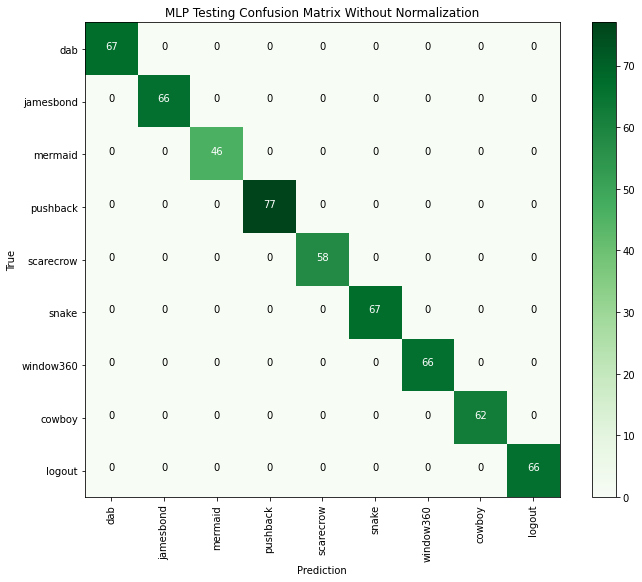

In [23]:
cnf_matrix = matrix
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10,8))
plot_confusion_matrix(cnf_matrix, classes=activities, title='MLP Testing Confusion Matrix Without Normalization')

In [24]:
plt.show()

Confusion Matrix With Normalization


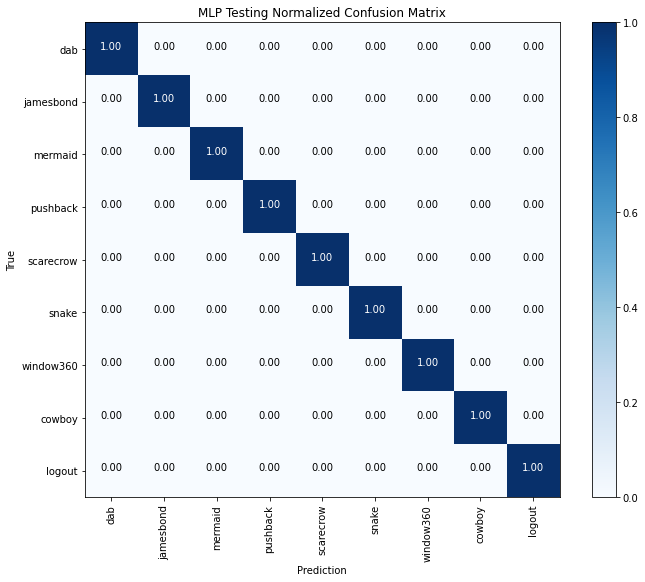

In [25]:
# Plot normalized confusion matrix
plt.figure(figsize=(10,8))
plot_confusion_matrix(cnf_matrix, classes=activities, normalize=True, title='MLP Testing Normalized Confusion Matrix')
plt.show()

In [26]:
for layerNum, layer in enumerate(model1.layers):
 #   print(layerNum)
    weights = layer.get_weights()[0]
    biases = layer.get_weights()[1]
    
    for toNeuronNum, bias in enumerate(biases):
        print(f'{layerNum}B -> L{layerNum+1}N{toNeuronNum}: {bias}')
        
    for fromNeuronNum, wgt in enumerate(weights):
        for toNeuronNum, wgt2 in enumerate(wgt):
            print(f'L{layerNum}N{fromNeuronNum} -> L{layerNum+1}N{toNeuronNum} = {wgt2}')

0B -> L1N0: 0.13104701042175293
0B -> L1N1: -0.07437620311975479
0B -> L1N2: 0.05277401581406593
0B -> L1N3: 0.17528508603572845
0B -> L1N4: -0.02291429229080677
0B -> L1N5: -0.0874662771821022
0B -> L1N6: -0.022167310118675232
0B -> L1N7: -0.08835597336292267
0B -> L1N8: -0.07263091206550598
0B -> L1N9: 0.011072182096540928
0B -> L1N10: 0.04534193500876427
0B -> L1N11: -0.06933120638132095
0B -> L1N12: 0.11094938218593597
0B -> L1N13: 0.09075050055980682
0B -> L1N14: -0.14573253691196442
0B -> L1N15: -0.04014116898179054
0B -> L1N16: 0.03814125433564186
0B -> L1N17: 0.04228970408439636
0B -> L1N18: -0.03452419862151146
0B -> L1N19: 0.01338945236057043
0B -> L1N20: -0.12964211404323578
0B -> L1N21: -0.005659191869199276
0B -> L1N22: 0.048623573035001755
0B -> L1N23: 0.11967870593070984
0B -> L1N24: 0.07128316909074783
0B -> L1N25: -0.006972978822886944
0B -> L1N26: -0.06119244918227196
0B -> L1N27: -0.10368169844150543
0B -> L1N28: -0.08468611538410187
0B -> L1N29: -0.01843145303428173

L0N11 -> L1N165 = -0.0570724681019783
L0N11 -> L1N166 = 0.013684632256627083
L0N11 -> L1N167 = 0.051852475851774216
L0N11 -> L1N168 = 0.19564443826675415
L0N11 -> L1N169 = -0.10828652232885361
L0N11 -> L1N170 = -0.057713109999895096
L0N11 -> L1N171 = -0.1597089022397995
L0N11 -> L1N172 = 0.08499718457460403
L0N11 -> L1N173 = -0.15563996136188507
L0N11 -> L1N174 = -0.18593424558639526
L0N11 -> L1N175 = -0.1893850713968277
L0N11 -> L1N176 = -0.015859127044677734
L0N11 -> L1N177 = -0.13792359828948975
L0N11 -> L1N178 = -0.0018105811905115843
L0N11 -> L1N179 = 0.04891495406627655
L0N11 -> L1N180 = -0.1445012092590332
L0N11 -> L1N181 = -0.016250303015112877
L0N11 -> L1N182 = -0.1394326239824295
L0N11 -> L1N183 = -0.15077942609786987
L0N11 -> L1N184 = 0.22011084854602814
L0N11 -> L1N185 = 0.12514129281044006
L0N11 -> L1N186 = 0.16967250406742096
L0N11 -> L1N187 = -0.17079249024391174
L0N11 -> L1N188 = -0.3113023340702057
L0N11 -> L1N189 = 0.2127743661403656
L0N11 -> L1N190 = 0.01498232688754

L0N23 -> L1N93 = 0.207692950963974
L0N23 -> L1N94 = -0.1339440643787384
L0N23 -> L1N95 = 0.09095637500286102
L0N23 -> L1N96 = 0.08967413753271103
L0N23 -> L1N97 = -0.029425734654068947
L0N23 -> L1N98 = -0.17319679260253906
L0N23 -> L1N99 = 0.3533695340156555
L0N23 -> L1N100 = -0.05811840295791626
L0N23 -> L1N101 = -0.02464602328836918
L0N23 -> L1N102 = 0.11096782237291336
L0N23 -> L1N103 = 0.08995643258094788
L0N23 -> L1N104 = 0.07836119830608368
L0N23 -> L1N105 = -0.17293699085712433
L0N23 -> L1N106 = -0.0792832151055336
L0N23 -> L1N107 = -0.14218369126319885
L0N23 -> L1N108 = 0.08060476928949356
L0N23 -> L1N109 = -0.16617977619171143
L0N23 -> L1N110 = 0.0348924845457077
L0N23 -> L1N111 = 0.07768276333808899
L0N23 -> L1N112 = -0.0575813390314579
L0N23 -> L1N113 = 0.12139729410409927
L0N23 -> L1N114 = 0.14608682692050934
L0N23 -> L1N115 = 0.18550477921962738
L0N23 -> L1N116 = -0.043358124792575836
L0N23 -> L1N117 = -0.31290024518966675
L0N23 -> L1N118 = -0.15437103807926178
L0N23 -> L1

L0N37 -> L1N8 = 0.09859086573123932
L0N37 -> L1N9 = -0.03821388632059097
L0N37 -> L1N10 = -0.018207965418696404
L0N37 -> L1N11 = 0.07126285135746002
L0N37 -> L1N12 = -0.005586026702076197
L0N37 -> L1N13 = -0.0628279373049736
L0N37 -> L1N14 = -0.013264083303511143
L0N37 -> L1N15 = -0.13380713760852814
L0N37 -> L1N16 = -0.06167866289615631
L0N37 -> L1N17 = -0.14449043571949005
L0N37 -> L1N18 = 0.0014562371652573347
L0N37 -> L1N19 = 0.05424671992659569
L0N37 -> L1N20 = 0.007497185375541449
L0N37 -> L1N21 = 0.09332756698131561
L0N37 -> L1N22 = 0.02865394577383995
L0N37 -> L1N23 = -0.09864335507154465
L0N37 -> L1N24 = 0.07567894458770752
L0N37 -> L1N25 = -0.14120902121067047
L0N37 -> L1N26 = -0.1009417325258255
L0N37 -> L1N27 = 0.05544321611523628
L0N37 -> L1N28 = 0.0006042766035534441
L0N37 -> L1N29 = 0.013837967999279499
L0N37 -> L1N30 = -0.0649540051817894
L0N37 -> L1N31 = -0.14953215420246124
L0N37 -> L1N32 = -0.0843324363231659
L0N37 -> L1N33 = -0.1457292139530182
L0N37 -> L1N34 = -0.0

L0N51 -> L1N11 = -0.09486711025238037
L0N51 -> L1N12 = -0.03990631178021431
L0N51 -> L1N13 = 0.046012263745069504
L0N51 -> L1N14 = 0.1347338706254959
L0N51 -> L1N15 = -0.11962755769491196
L0N51 -> L1N16 = 0.12246902287006378
L0N51 -> L1N17 = 0.04667910188436508
L0N51 -> L1N18 = 0.07229839265346527
L0N51 -> L1N19 = 0.009148338809609413
L0N51 -> L1N20 = 0.017772940918803215
L0N51 -> L1N21 = 0.06788600981235504
L0N51 -> L1N22 = 0.04974342882633209
L0N51 -> L1N23 = 0.06934478878974915
L0N51 -> L1N24 = -0.018322426825761795
L0N51 -> L1N25 = 0.01704801619052887
L0N51 -> L1N26 = 0.12008180469274521
L0N51 -> L1N27 = -0.050657209008932114
L0N51 -> L1N28 = 0.09202947467565536
L0N51 -> L1N29 = -0.057365283370018005
L0N51 -> L1N30 = 0.05167003348469734
L0N51 -> L1N31 = 0.026699241250753403
L0N51 -> L1N32 = 0.005167720839381218
L0N51 -> L1N33 = -0.017519555985927582
L0N51 -> L1N34 = -0.020129602402448654
L0N51 -> L1N35 = -0.03100559301674366
L0N51 -> L1N36 = 0.0643567219376564
L0N51 -> L1N37 = 0.08

L0N65 -> L1N253 = 0.08029890060424805
L0N65 -> L1N254 = -0.07438982278108597
L0N65 -> L1N255 = 0.057170480489730835
L0N66 -> L1N0 = -0.04779999330639839
L0N66 -> L1N1 = -0.061904098838567734
L0N66 -> L1N2 = -0.049527786672115326
L0N66 -> L1N3 = -0.0661277323961258
L0N66 -> L1N4 = -0.07729262113571167
L0N66 -> L1N5 = 0.14522144198417664
L0N66 -> L1N6 = -0.012935620732605457
L0N66 -> L1N7 = -0.028824590146541595
L0N66 -> L1N8 = 0.021961750462651253
L0N66 -> L1N9 = -0.16548599302768707
L0N66 -> L1N10 = 0.007673476357012987
L0N66 -> L1N11 = -0.08800096809864044
L0N66 -> L1N12 = -0.1862240880727768
L0N66 -> L1N13 = 0.021903401240706444
L0N66 -> L1N14 = -0.15339455008506775
L0N66 -> L1N15 = -0.018916182219982147
L0N66 -> L1N16 = -0.11471924930810928
L0N66 -> L1N17 = 0.09985078126192093
L0N66 -> L1N18 = -0.022015104070305824
L0N66 -> L1N19 = 0.13097883760929108
L0N66 -> L1N20 = 0.0011237247381359339
L0N66 -> L1N21 = -0.17672137916088104
L0N66 -> L1N22 = -0.20649175345897675
L0N66 -> L1N23 = 0

L1N13 -> L2N59 = -0.15736520290374756
L1N13 -> L2N60 = 0.03124164789915085
L1N13 -> L2N61 = -0.10187709331512451
L1N13 -> L2N62 = 0.05693626031279564
L1N13 -> L2N63 = 0.002269691089168191
L1N13 -> L2N64 = 0.08441758155822754
L1N13 -> L2N65 = 0.09760164469480515
L1N13 -> L2N66 = -0.0249404925853014
L1N13 -> L2N67 = 0.06815817952156067
L1N13 -> L2N68 = -0.10583893209695816
L1N13 -> L2N69 = 0.12664048373699188
L1N13 -> L2N70 = 0.12614738941192627
L1N13 -> L2N71 = 0.01157422550022602
L1N13 -> L2N72 = 0.031450968235731125
L1N13 -> L2N73 = 0.08827583491802216
L1N13 -> L2N74 = -0.01344123762100935
L1N13 -> L2N75 = -0.08569997549057007
L1N13 -> L2N76 = -0.1641354113817215
L1N13 -> L2N77 = 0.05494607612490654
L1N13 -> L2N78 = 0.03130161762237549
L1N13 -> L2N79 = -0.011270707473158836
L1N13 -> L2N80 = 0.06387852877378464
L1N13 -> L2N81 = 0.2154153436422348
L1N13 -> L2N82 = -0.036524903029203415
L1N13 -> L2N83 = 0.028112370520830154
L1N13 -> L2N84 = 0.048904068768024445
L1N13 -> L2N85 = -0.024981

L1N42 -> L2N42 = -0.004558441694825888
L1N42 -> L2N43 = -0.06042713299393654
L1N42 -> L2N44 = 0.17966656386852264
L1N42 -> L2N45 = -0.06555967032909393
L1N42 -> L2N46 = 0.11854997277259827
L1N42 -> L2N47 = -0.023037858307361603
L1N42 -> L2N48 = -0.06437798589468002
L1N42 -> L2N49 = -0.05194864794611931
L1N42 -> L2N50 = -0.03167032077908516
L1N42 -> L2N51 = -0.03181411325931549
L1N42 -> L2N52 = -0.01294358354061842
L1N42 -> L2N53 = -0.12620946764945984
L1N42 -> L2N54 = 0.025471273809671402
L1N42 -> L2N55 = -0.08359360694885254
L1N42 -> L2N56 = 0.07427757233381271
L1N42 -> L2N57 = 0.011328509077429771
L1N42 -> L2N58 = 0.08255831152200699
L1N42 -> L2N59 = -0.09514492005109787
L1N42 -> L2N60 = -0.041712068021297455
L1N42 -> L2N61 = -0.019376257434487343
L1N42 -> L2N62 = -0.08851658552885056
L1N42 -> L2N63 = 0.0822974145412445
L1N42 -> L2N64 = 0.13342998921871185
L1N42 -> L2N65 = -0.0908784419298172
L1N42 -> L2N66 = 0.038726985454559326
L1N42 -> L2N67 = 0.09713712334632874
L1N42 -> L2N68 = 

L1N73 -> L2N74 = 0.15625347197055817
L1N73 -> L2N75 = 0.04044702276587486
L1N73 -> L2N76 = -0.09404399245977402
L1N73 -> L2N77 = -0.027764782309532166
L1N73 -> L2N78 = -0.10869530588388443
L1N73 -> L2N79 = -0.08348339051008224
L1N73 -> L2N80 = 0.08288176357746124
L1N73 -> L2N81 = -0.08635182678699493
L1N73 -> L2N82 = -0.14750777184963226
L1N73 -> L2N83 = 0.03791528195142746
L1N73 -> L2N84 = -0.16769295930862427
L1N73 -> L2N85 = 0.015383534133434296
L1N73 -> L2N86 = 0.10045599192380905
L1N73 -> L2N87 = -0.09193618595600128
L1N73 -> L2N88 = -0.06844934821128845
L1N73 -> L2N89 = -0.10911043733358383
L1N73 -> L2N90 = 0.010123556479811668
L1N73 -> L2N91 = -0.0472065694630146
L1N73 -> L2N92 = -0.042744122445583344
L1N73 -> L2N93 = -0.04336891695857048
L1N73 -> L2N94 = -0.07001917064189911
L1N73 -> L2N95 = -0.02289246767759323
L1N73 -> L2N96 = 0.07653290778398514
L1N73 -> L2N97 = -0.11412592232227325
L1N73 -> L2N98 = -0.18705342710018158
L1N73 -> L2N99 = -0.05026402324438095
L1N73 -> L2N100 =

L1N100 -> L2N117 = -0.06297885626554489
L1N100 -> L2N118 = 0.05554864928126335
L1N100 -> L2N119 = 0.016299700364470482
L1N100 -> L2N120 = 0.1391385793685913
L1N100 -> L2N121 = -0.12248408794403076
L1N100 -> L2N122 = -0.06391537189483643
L1N100 -> L2N123 = -0.07557126879692078
L1N100 -> L2N124 = -0.114710234105587
L1N100 -> L2N125 = -0.09227854013442993
L1N100 -> L2N126 = -0.08695109188556671
L1N100 -> L2N127 = 0.061816200613975525
L1N101 -> L2N0 = 0.005122143775224686
L1N101 -> L2N1 = -0.10860905051231384
L1N101 -> L2N2 = -0.14282120764255524
L1N101 -> L2N3 = -0.11037901043891907
L1N101 -> L2N4 = 0.10259389877319336
L1N101 -> L2N5 = -0.0610235221683979
L1N101 -> L2N6 = -0.05066133290529251
L1N101 -> L2N7 = -0.17547154426574707
L1N101 -> L2N8 = 0.10272222012281418
L1N101 -> L2N9 = 0.007036891300231218
L1N101 -> L2N10 = 0.03717492148280144
L1N101 -> L2N11 = 0.09054691344499588
L1N101 -> L2N12 = -0.0788697600364685
L1N101 -> L2N13 = -0.0008512549684382975
L1N101 -> L2N14 = -0.144487440586

L1N129 -> L2N64 = 0.06850624829530716
L1N129 -> L2N65 = -0.029030634090304375
L1N129 -> L2N66 = 0.08893303573131561
L1N129 -> L2N67 = 0.13305258750915527
L1N129 -> L2N68 = -0.12856285274028778
L1N129 -> L2N69 = 0.009234231896698475
L1N129 -> L2N70 = 0.006110272835940123
L1N129 -> L2N71 = -0.07827507704496384
L1N129 -> L2N72 = 0.057116638869047165
L1N129 -> L2N73 = -0.027122318744659424
L1N129 -> L2N74 = -0.12549518048763275
L1N129 -> L2N75 = -0.07648767530918121
L1N129 -> L2N76 = -0.13818176090717316
L1N129 -> L2N77 = -0.09758063405752182
L1N129 -> L2N78 = 0.024516938254237175
L1N129 -> L2N79 = 0.05281996354460716
L1N129 -> L2N80 = 0.025351304560899734
L1N129 -> L2N81 = -0.029151780530810356
L1N129 -> L2N82 = -0.03277159482240677
L1N129 -> L2N83 = 0.009754308499395847
L1N129 -> L2N84 = 0.043569840490818024
L1N129 -> L2N85 = -0.045427728444337845
L1N129 -> L2N86 = 0.005899917799979448
L1N129 -> L2N87 = -0.07695081830024719
L1N129 -> L2N88 = 0.0359576940536499
L1N129 -> L2N89 = 0.0356079

L1N158 -> L2N72 = -0.037227991968393326
L1N158 -> L2N73 = -0.05982133746147156
L1N158 -> L2N74 = -0.19189129769802094
L1N158 -> L2N75 = -0.08306892961263657
L1N158 -> L2N76 = 0.02657162770628929
L1N158 -> L2N77 = 0.12355998903512955
L1N158 -> L2N78 = 0.0987129956483841
L1N158 -> L2N79 = 0.09239353239536285
L1N158 -> L2N80 = 0.08307952433824539
L1N158 -> L2N81 = 0.10774784535169601
L1N158 -> L2N82 = 0.07363859564065933
L1N158 -> L2N83 = -0.1451566517353058
L1N158 -> L2N84 = 0.1458677351474762
L1N158 -> L2N85 = 0.026906335726380348
L1N158 -> L2N86 = 0.07282321155071259
L1N158 -> L2N87 = 0.10430613905191422
L1N158 -> L2N88 = 0.02125885896384716
L1N158 -> L2N89 = 0.003208087757229805
L1N158 -> L2N90 = 0.11674308031797409
L1N158 -> L2N91 = 0.007518221158534288
L1N158 -> L2N92 = -0.035869043320417404
L1N158 -> L2N93 = 0.1291840672492981
L1N158 -> L2N94 = 0.04312387853860855
L1N158 -> L2N95 = -0.0833905041217804
L1N158 -> L2N96 = -0.11836180090904236
L1N158 -> L2N97 = -0.11369151622056961
L1N

L1N186 -> L2N68 = 0.03979307785630226
L1N186 -> L2N69 = 0.2022428810596466
L1N186 -> L2N70 = 0.03270496800541878
L1N186 -> L2N71 = -0.009952644817531109
L1N186 -> L2N72 = -0.1359936147928238
L1N186 -> L2N73 = 0.00916222669184208
L1N186 -> L2N74 = 0.03517988696694374
L1N186 -> L2N75 = -0.14835162460803986
L1N186 -> L2N76 = -0.01535759773105383
L1N186 -> L2N77 = 0.03910526633262634
L1N186 -> L2N78 = -0.16148655116558075
L1N186 -> L2N79 = 0.01616869494318962
L1N186 -> L2N80 = -0.039174884557724
L1N186 -> L2N81 = 0.11118130385875702
L1N186 -> L2N82 = -0.05028201639652252
L1N186 -> L2N83 = 0.005756933242082596
L1N186 -> L2N84 = -0.06178861856460571
L1N186 -> L2N85 = 0.07728295773267746
L1N186 -> L2N86 = -0.03190365806221962
L1N186 -> L2N87 = -0.14837193489074707
L1N186 -> L2N88 = 0.026214072480797768
L1N186 -> L2N89 = -0.06388180702924728
L1N186 -> L2N90 = 0.03219244256615639
L1N186 -> L2N91 = -0.06991426646709442
L1N186 -> L2N92 = 0.035937778651714325
L1N186 -> L2N93 = -0.04777441173791885

L1N214 -> L2N23 = 0.03361222892999649
L1N214 -> L2N24 = -0.0802987739443779
L1N214 -> L2N25 = -0.02204291522502899
L1N214 -> L2N26 = 0.06674642115831375
L1N214 -> L2N27 = 0.10150528699159622
L1N214 -> L2N28 = -0.02802831307053566
L1N214 -> L2N29 = 0.12779849767684937
L1N214 -> L2N30 = -0.020730452612042427
L1N214 -> L2N31 = -0.1791529655456543
L1N214 -> L2N32 = 0.03972030058503151
L1N214 -> L2N33 = -0.07494781166315079
L1N214 -> L2N34 = 0.0520123727619648
L1N214 -> L2N35 = -0.030733661726117134
L1N214 -> L2N36 = -0.030637593939900398
L1N214 -> L2N37 = -0.13980545103549957
L1N214 -> L2N38 = 0.08890561014413834
L1N214 -> L2N39 = 0.04356342926621437
L1N214 -> L2N40 = 0.10557079315185547
L1N214 -> L2N41 = 0.11844220012426376
L1N214 -> L2N42 = -0.08164455741643906
L1N214 -> L2N43 = 0.002483605407178402
L1N214 -> L2N44 = 0.05127435550093651
L1N214 -> L2N45 = -0.14956605434417725
L1N214 -> L2N46 = 0.0682528167963028
L1N214 -> L2N47 = 0.13039880990982056
L1N214 -> L2N48 = -0.059475984424352646

L1N245 -> L2N55 = -0.008875928819179535
L1N245 -> L2N56 = -0.12347935885190964
L1N245 -> L2N57 = 0.13521119952201843
L1N245 -> L2N58 = -0.047912802547216415
L1N245 -> L2N59 = -0.12317027151584625
L1N245 -> L2N60 = 0.004851601552218199
L1N245 -> L2N61 = -0.10752098262310028
L1N245 -> L2N62 = -0.09476843476295471
L1N245 -> L2N63 = -0.0646999180316925
L1N245 -> L2N64 = 0.18095996975898743
L1N245 -> L2N65 = -0.11340431123971939
L1N245 -> L2N66 = 0.057837143540382385
L1N245 -> L2N67 = 0.12237681448459625
L1N245 -> L2N68 = -0.10694655776023865
L1N245 -> L2N69 = -0.010631432756781578
L1N245 -> L2N70 = -0.0018896091496571898
L1N245 -> L2N71 = -0.033719900995492935
L1N245 -> L2N72 = 0.006399071775376797
L1N245 -> L2N73 = 0.0776078850030899
L1N245 -> L2N74 = 0.01598409190773964
L1N245 -> L2N75 = -0.05926857516169548
L1N245 -> L2N76 = -0.08570496737957001
L1N245 -> L2N77 = 0.12563692033290863
L1N245 -> L2N78 = -0.10608401149511337
L1N245 -> L2N79 = -0.06054473668336868
L1N245 -> L2N80 = -0.115152

In [27]:
# #With minmax
# # Dense: Fully connected layer and the most common type of layer used on multi-layer perceptron models.
# # Dropout: Apply dropout to the model, setting a fraction of inputs to zero in an effort to reduce over fitting.
# # Merge: Combine the inputs from multiple models into a single model.
model = Sequential()
bias_initializer = HeNormal()

# First hidden layer
model.add(Dense(256, input_shape = (72,), activation = 'relu', use_bias=True, bias_initializer=bias_initializer))

# Randomly drop 30% of this layer for training
model.add(Dropout(0.3))

model.add(Dense(128, activation = 'relu', use_bias=True, bias_initializer=bias_initializer))
model.add(Dropout(0.3))

# Finally our output with softmax activation
model.add(Dense(9, activation = 'softmax'))

sgd  = SGD(learning_rate = 0.01, decay = 1e-6, momentum = 0.9)

model.compile(loss = 'categorical_crossentropy', optimizer = sgd,
            metrics = 'accuracy')

In [28]:
from sklearn.preprocessing import MinMaxScaler
X_train = X_train.reshape(X_train.shape[0], 72)
X_test = X_test.reshape(X_test.shape[0], 72)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

scaler = MinMaxScaler(feature_range = (0, 1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [29]:
print(y_train)
print(y_train.shape)

[[0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
(1165, 9)


In [30]:
model.fit(x = X_train, y = y_train, shuffle = True, batch_size = 60, 
          epochs = 500, validation_data = (X_test, y_test))

Epoch 1/500
20/20 [==============================] - 0s 6ms/step - loss: 2.1550 - accuracy: 0.1794 - val_loss: 2.0494 - val_accuracy: 0.6365
Epoch 2/500
20/20 [==============================] - 0s 2ms/step - loss: 1.9565 - accuracy: 0.3897 - val_loss: 1.8235 - val_accuracy: 0.7948
Epoch 3/500
20/20 [==============================] - 0s 2ms/step - loss: 1.6501 - accuracy: 0.5811 - val_loss: 1.4857 - val_accuracy: 0.8122
Epoch 4/500
20/20 [==============================] - 0s 2ms/step - loss: 1.3018 - accuracy: 0.6712 - val_loss: 1.0914 - val_accuracy: 0.8974
Epoch 5/500
20/20 [==============================] - 0s 2ms/step - loss: 0.9660 - accuracy: 0.7639 - val_loss: 0.8052 - val_accuracy: 0.9426
Epoch 6/500
20/20 [==============================] - 0s 2ms/step - loss: 0.7356 - accuracy: 0.8215 - val_loss: 0.6747 - val_accuracy: 0.8852
Epoch 7/500
20/20 [==============================] - 0s 2ms/step - loss: 0.6024 - accuracy: 0.8446 - val_loss: 0.5734 - val_accuracy: 0.9200
Epoch 8/500
2

Epoch 59/500
20/20 [==============================] - 0s 2ms/step - loss: 0.0399 - accuracy: 0.9897 - val_loss: 0.1759 - val_accuracy: 0.9391
Epoch 60/500
20/20 [==============================] - 0s 2ms/step - loss: 0.0443 - accuracy: 0.9906 - val_loss: 0.1758 - val_accuracy: 0.9391
Epoch 61/500
20/20 [==============================] - 0s 2ms/step - loss: 0.0371 - accuracy: 0.9931 - val_loss: 0.1560 - val_accuracy: 0.9496
Epoch 62/500
20/20 [==============================] - 0s 2ms/step - loss: 0.0425 - accuracy: 0.9923 - val_loss: 0.1370 - val_accuracy: 0.9565
Epoch 63/500
20/20 [==============================] - 0s 2ms/step - loss: 0.0379 - accuracy: 0.9931 - val_loss: 0.1377 - val_accuracy: 0.9583
Epoch 64/500
20/20 [==============================] - 0s 2ms/step - loss: 0.0398 - accuracy: 0.9914 - val_loss: 0.1522 - val_accuracy: 0.9496
Epoch 65/500
20/20 [==============================] - 0s 2ms/step - loss: 0.0424 - accuracy: 0.9914 - val_loss: 0.1450 - val_accuracy: 0.9583
Epoch 

20/20 [==============================] - 0s 2ms/step - loss: 0.0149 - accuracy: 0.9991 - val_loss: 0.1538 - val_accuracy: 0.9513
Epoch 117/500
20/20 [==============================] - 0s 2ms/step - loss: 0.0210 - accuracy: 0.9948 - val_loss: 0.1255 - val_accuracy: 0.9600
Epoch 118/500
20/20 [==============================] - 0s 2ms/step - loss: 0.0182 - accuracy: 0.9966 - val_loss: 0.1045 - val_accuracy: 0.9687
Epoch 119/500
20/20 [==============================] - 0s 2ms/step - loss: 0.0193 - accuracy: 0.9957 - val_loss: 0.1353 - val_accuracy: 0.9600
Epoch 120/500
20/20 [==============================] - 0s 2ms/step - loss: 0.0174 - accuracy: 0.9966 - val_loss: 0.1241 - val_accuracy: 0.9617
Epoch 121/500
20/20 [==============================] - 0s 2ms/step - loss: 0.0206 - accuracy: 0.9931 - val_loss: 0.1166 - val_accuracy: 0.9652
Epoch 122/500
20/20 [==============================] - 0s 2ms/step - loss: 0.0185 - accuracy: 0.9974 - val_loss: 0.1090 - val_accuracy: 0.9652
Epoch 123/500

20/20 [==============================] - 0s 2ms/step - loss: 0.0116 - accuracy: 0.9974 - val_loss: 0.1112 - val_accuracy: 0.9687
Epoch 174/500
20/20 [==============================] - 0s 2ms/step - loss: 0.0123 - accuracy: 0.9966 - val_loss: 0.1146 - val_accuracy: 0.9652
Epoch 175/500
20/20 [==============================] - 0s 2ms/step - loss: 0.0107 - accuracy: 0.9983 - val_loss: 0.1149 - val_accuracy: 0.9652
Epoch 176/500
20/20 [==============================] - 0s 2ms/step - loss: 0.0111 - accuracy: 0.9983 - val_loss: 0.1053 - val_accuracy: 0.9652
Epoch 177/500
20/20 [==============================] - 0s 2ms/step - loss: 0.0161 - accuracy: 0.9957 - val_loss: 0.1027 - val_accuracy: 0.9670
Epoch 178/500
20/20 [==============================] - 0s 2ms/step - loss: 0.0136 - accuracy: 0.9966 - val_loss: 0.1126 - val_accuracy: 0.9652
Epoch 179/500
20/20 [==============================] - 0s 2ms/step - loss: 0.0091 - accuracy: 1.0000 - val_loss: 0.1361 - val_accuracy: 0.9565
Epoch 180/500

20/20 [==============================] - 0s 2ms/step - loss: 0.0102 - accuracy: 0.9974 - val_loss: 0.1187 - val_accuracy: 0.9635
Epoch 231/500
20/20 [==============================] - 0s 2ms/step - loss: 0.0077 - accuracy: 0.9991 - val_loss: 0.1197 - val_accuracy: 0.9617
Epoch 232/500
20/20 [==============================] - 0s 2ms/step - loss: 0.0084 - accuracy: 0.9991 - val_loss: 0.1344 - val_accuracy: 0.9565
Epoch 233/500
20/20 [==============================] - 0s 2ms/step - loss: 0.0089 - accuracy: 0.9983 - val_loss: 0.1238 - val_accuracy: 0.9600
Epoch 234/500
20/20 [==============================] - 0s 2ms/step - loss: 0.0080 - accuracy: 0.9991 - val_loss: 0.1179 - val_accuracy: 0.9600
Epoch 235/500
20/20 [==============================] - 0s 2ms/step - loss: 0.0077 - accuracy: 0.9991 - val_loss: 0.1107 - val_accuracy: 0.9652
Epoch 236/500
20/20 [==============================] - 0s 2ms/step - loss: 0.0109 - accuracy: 0.9983 - val_loss: 0.1226 - val_accuracy: 0.9600
Epoch 237/500

20/20 [==============================] - 0s 2ms/step - loss: 0.0056 - accuracy: 0.9991 - val_loss: 0.1262 - val_accuracy: 0.9600
Epoch 288/500
20/20 [==============================] - 0s 2ms/step - loss: 0.0079 - accuracy: 0.9991 - val_loss: 0.1389 - val_accuracy: 0.9565
Epoch 289/500
20/20 [==============================] - 0s 2ms/step - loss: 0.0104 - accuracy: 0.9974 - val_loss: 0.1203 - val_accuracy: 0.9652
Epoch 290/500
20/20 [==============================] - 0s 2ms/step - loss: 0.0062 - accuracy: 0.9991 - val_loss: 0.1223 - val_accuracy: 0.9652
Epoch 291/500
20/20 [==============================] - 0s 2ms/step - loss: 0.0051 - accuracy: 0.9991 - val_loss: 0.1171 - val_accuracy: 0.9652
Epoch 292/500
20/20 [==============================] - 0s 2ms/step - loss: 0.0058 - accuracy: 0.9983 - val_loss: 0.1195 - val_accuracy: 0.9652
Epoch 293/500
20/20 [==============================] - 0s 2ms/step - loss: 0.0072 - accuracy: 0.9991 - val_loss: 0.1252 - val_accuracy: 0.9635
Epoch 294/500

20/20 [==============================] - 0s 2ms/step - loss: 0.0039 - accuracy: 0.9991 - val_loss: 0.1168 - val_accuracy: 0.9652
Epoch 345/500
20/20 [==============================] - 0s 2ms/step - loss: 0.0058 - accuracy: 0.9991 - val_loss: 0.1149 - val_accuracy: 0.9652
Epoch 346/500
20/20 [==============================] - 0s 2ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.1109 - val_accuracy: 0.9687
Epoch 347/500
20/20 [==============================] - 0s 2ms/step - loss: 0.0039 - accuracy: 0.9991 - val_loss: 0.1112 - val_accuracy: 0.9687
Epoch 348/500
20/20 [==============================] - 0s 2ms/step - loss: 0.0046 - accuracy: 0.9991 - val_loss: 0.1166 - val_accuracy: 0.9652
Epoch 349/500
20/20 [==============================] - 0s 2ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.1192 - val_accuracy: 0.9652
Epoch 350/500
20/20 [==============================] - 0s 2ms/step - loss: 0.0061 - accuracy: 0.9983 - val_loss: 0.1136 - val_accuracy: 0.9600
Epoch 351/500

20/20 [==============================] - 0s 2ms/step - loss: 0.0044 - accuracy: 0.9983 - val_loss: 0.1049 - val_accuracy: 0.9704
Epoch 402/500
20/20 [==============================] - 0s 2ms/step - loss: 0.0043 - accuracy: 0.9991 - val_loss: 0.1105 - val_accuracy: 0.9687
Epoch 403/500
20/20 [==============================] - 0s 2ms/step - loss: 0.0047 - accuracy: 0.9991 - val_loss: 0.1072 - val_accuracy: 0.9704
Epoch 404/500
20/20 [==============================] - 0s 2ms/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.1086 - val_accuracy: 0.9704
Epoch 405/500
20/20 [==============================] - 0s 2ms/step - loss: 0.0038 - accuracy: 1.0000 - val_loss: 0.1127 - val_accuracy: 0.9704
Epoch 406/500
20/20 [==============================] - 0s 2ms/step - loss: 0.0051 - accuracy: 0.9991 - val_loss: 0.1248 - val_accuracy: 0.9635
Epoch 407/500
20/20 [==============================] - 0s 2ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.1366 - val_accuracy: 0.9600
Epoch 408/500

20/20 [==============================] - 0s 2ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.1156 - val_accuracy: 0.9687
Epoch 459/500
20/20 [==============================] - 0s 2ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.1173 - val_accuracy: 0.9652
Epoch 460/500
20/20 [==============================] - 0s 2ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.1181 - val_accuracy: 0.9687
Epoch 461/500
20/20 [==============================] - 0s 2ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.1245 - val_accuracy: 0.9652
Epoch 462/500
20/20 [==============================] - 0s 2ms/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.1383 - val_accuracy: 0.9600
Epoch 463/500
20/20 [==============================] - 0s 2ms/step - loss: 0.0047 - accuracy: 0.9983 - val_loss: 0.1342 - val_accuracy: 0.9617
Epoch 464/500
20/20 [==============================] - 0s 2ms/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.1159 - val_accuracy: 0.9652
Epoch 465/500

In [31]:
loss, acc = model.evaluate(x = X_test, y = y_test)
print("Final loss is %3.2f, accuracy is %3.2f." % (loss, acc))

18/18 [==============================] - 0s 530us/step - loss: 0.1147 - accuracy: 0.9687
Final loss is 0.11, accuracy is 0.97.


In [32]:
# Merge inputs and targets
inputs = np.concatenate((X_train, X_test), axis=0)
targets = np.concatenate((y_train, y_test), axis=0)

# Define the K-fold Cross Validator
kfold = KFold(n_splits=10, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(inputs, targets):

    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Fit data to model
    history = model1.fit(inputs[train], targets[train],
              batch_size=60,
              epochs=10)

    # Generate generalization metrics
    scores = model1.evaluate(inputs[test], targets[test], verbose=0)
    print(f'Score for fold {fold_no}: {model1.metrics_names[0]} of {scores[0]}; {model1.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold = []
    loss_per_fold = []
    acc_per_fold.append(scores[1]*100)
    loss_per_fold.append(scores[0])

    # Increase fold number
    fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/10
27/27 [==============================] - 0s 885us/step - loss: 0.8926 - accuracy: 0.7931
Epoch 2/10
27/27 [==============================] - 0s 808us/step - loss: 0.4469 - accuracy: 0.9834
Epoch 3/10
27/27 [==============================] - 0s 769us/step - loss: 0.3812 - accuracy: 0.9885
Epoch 4/10
27/27 [==============================] - 0s 808us/step - loss: 0.3422 - accuracy: 0.9911
Epoch 5/10
27/27 [==============================] - 0s 769us/step - loss: 0.3127 - accuracy: 0.9936
Epoch 6/10
27/27 [==============================] - 0s 808us/step - loss: 0.2894 - accuracy: 0.9936
Epoch 7/10
27/27 [==============================] - 0s 731us/step - loss: 0.2677 - accuracy: 0.9917
Epoch 8/10
27/27 [==============================] - 0s 731us/step - loss: 0.2513 - accuracy: 0.9936
Epoch 9/10
27/27 [==============================] - 0s 731us/step - loss: 0.2344 - accuracy: 0.9917
Epo

------------------------------------------------------------------------
Training for fold 8 ...
Epoch 1/10
27/27 [==============================] - 0s 962us/step - loss: 0.0464 - accuracy: 0.9968
Epoch 2/10
27/27 [==============================] - 0s 1ms/step - loss: 0.0456 - accuracy: 0.9974
Epoch 3/10
27/27 [==============================] - 0s 961us/step - loss: 0.0457 - accuracy: 0.9968
Epoch 4/10
27/27 [==============================] - 0s 962us/step - loss: 0.0448 - accuracy: 0.9968
Epoch 5/10
27/27 [==============================] - 0s 923us/step - loss: 0.0443 - accuracy: 0.9968
Epoch 6/10
27/27 [==============================] - 0s 961us/step - loss: 0.0445 - accuracy: 0.9962
Epoch 7/10
27/27 [==============================] - 0s 923us/step - loss: 0.0433 - accuracy: 0.9962
Epoch 8/10
27/27 [==============================] - 0s 769us/step - loss: 0.0435 - accuracy: 0.9962
Epoch 9/10
27/27 [==============================] - 0s 731us/step - loss: 0.0427 - accuracy: 0.9962
Epoch

In [33]:
predictions = model.predict(x = X_test)
predictions

array([[2.20e-06, 1.00e+00, 1.47e-09, ..., 1.73e-05, 9.54e-08, 1.47e-06],
       [5.56e-08, 3.57e-08, 6.84e-23, ..., 1.00e+00, 2.77e-13, 6.95e-10],
       [1.42e-10, 1.73e-06, 6.71e-08, ..., 3.39e-10, 1.00e+00, 1.31e-09],
       ...,
       [1.23e-08, 1.01e-07, 1.76e-15, ..., 6.43e-06, 2.38e-09, 1.00e+00],
       [4.76e-08, 9.85e-01, 1.19e-02, ..., 2.25e-08, 1.92e-03, 2.42e-06],
       [2.15e-11, 8.19e-08, 1.00e+00, ..., 8.35e-14, 5.72e-08, 1.91e-11]],
      dtype=float32)

In [34]:
matrix = confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1))

Confusion Matrix Without Normalization
Confusion Matrix With Normalization


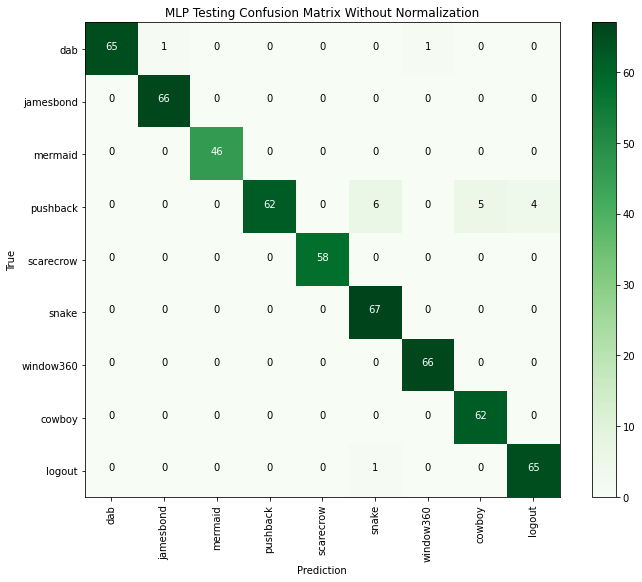

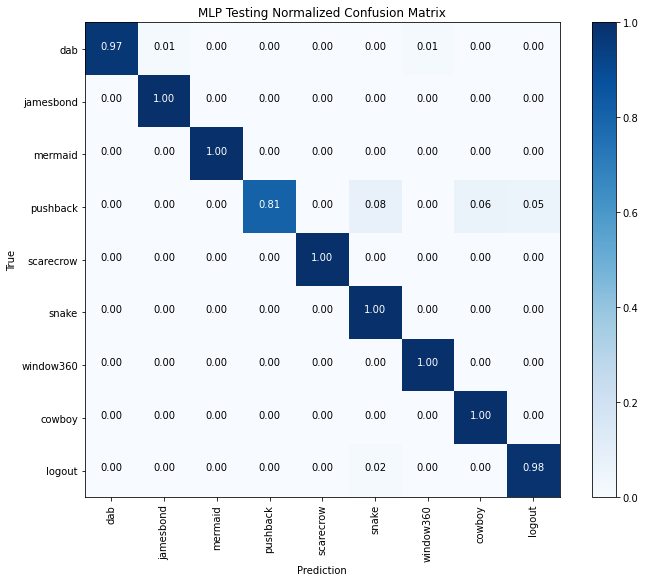

In [35]:
cnf_matrix = matrix
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10,8))
plot_confusion_matrix(cnf_matrix, classes=activities, title='MLP Testing Confusion Matrix Without Normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(10,8))
plot_confusion_matrix(cnf_matrix, classes=activities, normalize=True, title='MLP Testing Normalized Confusion Matrix')

plt.show()
